# Importe De Librerías

In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from six import StringIO
import pydotplus
from IPython.display import Image  
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('always')
from sklearn.linear_model import LinearRegression
from sklearn import tree, preprocessing, model_selection, ensemble

# Regresión

### Lectura de archivos

In [2]:
ds_regresion = pd.read_csv("properati_argentina_reducido_train.csv")
test = pd.read_csv("properati_argentina_reducido_test.csv")

variables_a_eliminar = ["Unnamed: 0"]

ds_regresion.drop(columns=variables_a_eliminar, inplace=True)
test.drop(columns = variables_a_eliminar, inplace=True)

## KNN

### Preparo el dataset


In [3]:
ds_train_knn = ds_regresion.copy()
ds_test_knn = test.copy()

#### Min-Max

In [4]:
scaler = MinMaxScaler()
ds_train_knn["property_surface_total"] = scaler.fit_transform(ds_train_knn["property_surface_total"].to_frame())
ds_train_knn["property_rooms"] = scaler.fit_transform(ds_train_knn["property_rooms"].to_frame())
ds_train_knn["longitud"] = scaler.fit_transform(ds_train_knn["longitud"].to_frame())
ds_train_knn["latitud"] = scaler.fit_transform(ds_train_knn["latitud"].to_frame())


ds_test_knn["property_surface_total"] = scaler.fit_transform(ds_test_knn["property_surface_total"].to_frame())
ds_test_knn["property_rooms"] = scaler.fit_transform(ds_test_knn["property_rooms"].to_frame())
ds_test_knn["longitud"] = scaler.fit_transform(ds_test_knn["longitud"].to_frame())
ds_test_knn["latitud"] = scaler.fit_transform(ds_test_knn["latitud"].to_frame())

#### One Hot Encoding

In [5]:
ds_train_knn = pd.get_dummies(ds_train_knn, columns=["property_type"], drop_first=True)
ds_test_knn = pd.get_dummies(ds_test_knn, columns=["property_type"], drop_first=True)

In [6]:
ds_train_knn.head()

,latitud,longitud,property_rooms,property_surface_total,property_price,property_type_Departamento,property_type_PH
0,0.856747,0.455186,0.051282,0.000337,179000.0,1,0
1,0.543607,0.477971,0.051282,0.000344,160000.0,1,0
2,0.506321,0.808948,0.000000,0.000181,67900.0,1,0
3,0.488165,0.420215,0.000000,0.000169,80000.0,1,0
4,0.572198,0.613199,0.025641,0.000163,68000.0,1,0


In [7]:
ds_test_knn.head()

,latitud,longitud,property_rooms,property_surface_total,property_price,property_type_Departamento,property_type_PH
0,0.748053,0.510308,0.333333,0.000540,140000.0,1,0
1,0.785849,0.272786,0.333333,0.000474,170000.0,1,0
2,0.640697,0.775623,0.500000,0.001533,750000.0,1,0
3,0.403258,0.231545,0.333333,0.000467,130000.0,1,0
4,0.688966,0.581890,0.000000,0.000073,55000.0,1,0


### Modelo

#### Optimizacion de parametros con Random search

In [8]:
x_train = ds_train_knn.drop(columns=["property_price"])
y_train = ds_train_knn["property_price"]

Buscamos los mejores hiperparametros usando randomized search que optimizen el MSE, ya que es la medida que nos interesa a al hora de hacer regresion. Queremos calcular el error medio de las predicciones

Utilizamos 10 folds

In [9]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Metrica que quiero optimizar MSE
scorer_fn = make_scorer(sklearn.metrics.mean_squared_error)

#Clasificador KNN
knn=KNeighborsRegressor()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring=scorer_fn, n_iter=10, random_state=5)

rand.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': range(1, 30),
                                        'weights': ['distance', 'uniform']},
                   random_state=5, scoring=make_scorer(mean_squared_error))

In [10]:
#Mejores hiperparametros
print(rand.best_params_)

#Mejor métrica
mse = rand.best_score_
print("RMSE en datos de entrnamiento: " + str(np.sqrt(mse)))


{'weights': 'uniform', 'n_neighbors': 24, 'metric': 'chebyshev', 'algorithm': 'ball_tree'}
RMSE en datos de entrnamiento: 96852.20306412312


In [11]:
#Mejor estimador
best_knn=rand.best_estimator_

x_test_knn = ds_test_knn.drop(columns=["property_price"])
y_test_knn = ds_test_knn["property_price"]

y_pred_knn = best_knn.predict(x_test_knn)

Medimos que tan precisas fueron las predicciones usando RMSE. La ventaja de usar RMSE en vez de MSE es que el valor de RMSE está en las mismas unidades que la variable target. De esta forma es más fácil dimensionar que tan preciso es el modelo creado

In [12]:
#Metricas para evaluar modelos
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_knn,
        y_pred  = y_pred_knn,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_knn,
        y_pred  = y_pred_knn,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

El error (mse) de test es: 90643332488.66307
El error (rmse) de test es: 301070.3115364633


Persistimos el modelo

In [ ]:
filename = "knn.sav"
pickle.dump(best_knn, open(filename, 'wb'))

## XGBoost

In [14]:
ds_prop_XGBoost_train = ds_regresion.copy()
ds_prop_XGBoost_test = test.copy()

ds_prop_XGBoost_train = ds_prop_XGBoost_train.dropna()
ds_prop_XGBoost_test = ds_prop_XGBoost_test.dropna()

Realizamos la ingeniería de caracteristicas para cada dataset

In [15]:
#One Hot Encoding para variables categoricas

variables_reemplazadas = ["property_type"]
ds_prop_XGBoost_train = pd.get_dummies(ds_prop_XGBoost_train, columns=variables_reemplazadas, drop_first=True)
ds_prop_XGBoost_test = pd.get_dummies(ds_prop_XGBoost_test, columns=variables_reemplazadas, drop_first=True)

#Escalamos las variables para que no tengan mayor peso
standard_scaler = StandardScaler()

ds_prop_XGBoost_train["property_surface_total"] = standard_scaler.fit_transform(ds_prop_XGBoost_train["property_surface_total"].to_frame())
ds_prop_XGBoost_train["longitud"] = standard_scaler.fit_transform(ds_prop_XGBoost_train["longitud"].to_frame())
ds_prop_XGBoost_train["latitud"] = standard_scaler.fit_transform(ds_prop_XGBoost_train["latitud"].to_frame())
ds_prop_XGBoost_train["property_rooms"] = standard_scaler.fit_transform(ds_prop_XGBoost_train["property_rooms"].to_frame())

ds_prop_XGBoost_test["property_surface_total"] = standard_scaler.fit_transform(ds_prop_XGBoost_test["property_surface_total"].to_frame())
ds_prop_XGBoost_test["longitud"] = standard_scaler.fit_transform(ds_prop_XGBoost_test["longitud"].to_frame())
ds_prop_XGBoost_test["latitud"] = standard_scaler.fit_transform(ds_prop_XGBoost_test["latitud"].to_frame())
ds_prop_XGBoost_test["property_rooms"] = standard_scaler.fit_transform(ds_prop_XGBoost_test["property_rooms"].to_frame())



In [16]:
#Hacemos division Train-Test
features = ['property_rooms','property_surface_total','latitud','longitud', 'property_type_PH', 'property_type_Departamento']
target = ["property_price"]

x_train = ds_prop_XGBoost_train[features]
x_test = ds_prop_XGBoost_test[features]

y_train = ds_prop_XGBoost_train[target]
y_test = ds_prop_XGBoost_test[target]

Buscamos los mejores hiperparametros usando Random CV. Usamos Random CV para hallar los hiperparametros que optimizen el MSE, ya que es la medida que nos interesa a al hora de hacer regresion. Queremos calcular el error medio de las predicciones

In [17]:
#KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],                  #Luego de probar con varias combinaciones de parametros se
               'ccp_alpha':np.linspace(0,0.5,15),               #llegó a la conclusión de que Random Search encuentra los
               'max_depth':list(range(3,4)),                    #hiperparametros más adecuados con esta grilla 
               'random_state':list(range(0,6)),                 #de parametros
               'gamma':list(range(31,32)),
               'min_child_weight':list(range(17,18)),
               'colsample_bytree':np.linspace(0.75,0.8,15)}
                
#Cantidad de splits para el Cross Validation
folds=8

#Regresor
xgb_model_rd_search = xgb.XGBRegressor()

#Metrica que quiero optimizar MSE
scorer_fn = make_scorer(sklearn.metrics.mean_squared_error)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=xgb_model_rd_search,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              n_iter=n, cv=folds) 


#Busco los hiperparamtros que optimizan MSE
randomcv.fit(x_train,y_train)

[12:47:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "ccp_alpha", "criterion" } are not used.

[12:47:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "ccp_alpha", "criterion" } are not used.

[12:47:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "ccp_alpha", "criterion" } are not used.

[12:47:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "ccp_alpha", "criterion" } are not used.

[12:47:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:76

RandomizedSearchCV(cv=8,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
       0.35714286, 0.39285714, 0.42857143, 0.46428571, 0.5       ]),
                                        'colsample_bytree': array([0.75      , 0.75357143, 0.75714286, 0.76071429, 0.76428571,
       0.76785714, 0.77142857, 0.775     , 0.77857143, 0.78214286,
       0.78571429, 0.78928571, 0.79285714, 0.79642857, 0.8       ]),
                                        'criterion': ['gini', 'entropy'],
                                        'gamma': [31], 'max_depth': [3],
                                        'min_child_weight': [17],
                                        'random_state': [0, 1, 2, 3, 4, 5]},
                   scoring=make_scorer(mean_squared_error))

In [18]:
#Mejores hiperparametros
print(randomcv.best_params_)

#Mejor métrica
mse = randomcv.best_score_
print("RMSE en datos de entrnamiento: " + str(np.sqrt(mse)))

{'random_state': 1, 'min_child_weight': 17, 'max_depth': 3, 'gamma': 31, 'criterion': 'gini', 'colsample_bytree': 0.7964285714285715, 'ccp_alpha': 0.3571428571428571}
RMSE en datos de entrnamiento: 81271.23756883561


Entrenamos el modelo

In [19]:
xgb_model = xgb.XGBRegressor().set_params(**randomcv.best_params_)
xgb_model.fit(x_train, y_train)

[12:49:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "ccp_alpha", "criterion" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             ccp_alpha=0.3571428571428571, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7964285714285715,
             criterion='gini', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=31, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=17, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, ...)

Medimos que tan precisas fueron las predicciones usando RMSE. La ventaja de usar RMSE en vez de MSE es que el valor de RMSE está en las mismas unidades que la variable target. De esta forma es más fácil dimensionar que tan preciso es el modelo creado

In [20]:
from sklearn.metrics import mean_squared_error

y_pred = xgb_model.predict(x_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE en datos de test: " + str(rmse))

RMSE en datos de test: 120292.57465775193


Vemos que la performance de entrenamiento y la del conjunto de evaluación es bastante similar. Esto significa que no hay overfitting, es decir, el modelo no se aprende de 'memoria' los datos de entrenamiento y no pierde mucha precision al realizar las predicciones en el conjunto de evaluación. 

In [21]:
#Atributos considerados y su importancia
sorted(list(zip(x_train.columns.to_list(), xgb_model.feature_importances_)), key=lambda x: -x[1])

[('property_rooms', 0.42283595),
 ('property_type_PH', 0.1603838),
 ('property_type_Departamento', 0.1333791),
 ('latitud', 0.10858352),
 ('property_surface_total', 0.10630986),
 ('longitud', 0.06850775)]

Por ultimo, persistimos el modelo

In [ ]:
filename = "xgb_model.sav"
pickle.dump(xgb_model, open(filename, 'wb'))

## AdaBoost

Elegimos como último modelo el algortimo de AdaBoost.
Consiste en entrenar un predictor, un clasificador base, verificar los errores que comete y entrenar luego otro predictor para corregir los errores. AdaBoost repite el proceso hasta reducir el error o encontrar el predictor perfecto.
En conclusión se combinan estimadores débiles para poder hacer clasificaciones.

In [ ]:

##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=5
#Conjunto de parámetros que quiero usar
params_grid = {"learning_rate":(2,5),
               'n_estimators':(100,200),
               'random_state':list(range(0,6))}
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
#kfoldcv = StratifiedKFold(n_splits=folds)

#Regresor
ab_model = AdaBoostRegressor(n_estimators=10, random_state=0)

#Metrica que quiero optimizar MSE
scorer_fn = make_scorer(sklearn.metrics.mean_squared_error)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=ab_model,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              n_iter=n, cv=folds) 


#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train)

In [ ]:
#Mejores hiperparametros
print(randomcv.best_params_)

#Mejor métrica
mse = randomcv.best_score_
print("RMSE en datos de entrnamiento: " + str(np.sqrt(mse)))

['property_rooms',
 'property_surface_total',
 'latitud',
 'longitud',
 'property_type_PH',
 'property_type_Departamento']

In [ ]:
# Grafico el primer STUMP

dot_data = StringIO()
export_graphviz(ab_model.estimators_[0], out_file=dot_data,   filled=True, rounded=True,
                special_characters=True,feature_names=features,class_names=['No','Yes'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## GradientBoost

In [40]:
ds_prop_GBoost_train = ds_regresion.copy()
ds_prop_GBoost_test = test.copy()

In [41]:
#One Hot Encoding para variables categoricas

variables_reemplazadas = ["property_type"]
ds_prop_GBoost_train = pd.get_dummies(ds_prop_GBoost_train, columns=variables_reemplazadas, drop_first=True)
ds_prop_GBoost_test = pd.get_dummies(ds_prop_GBoost_test, columns=variables_reemplazadas, drop_first=True)

#Escalamos las variables para que no tengan mayor peso
scaler = MinMaxScaler()

ds_prop_GBoost_train["property_surface_total"] = scaler.fit_transform(ds_prop_GBoost_train["property_surface_total"].to_frame())
ds_prop_GBoost_train["longitud"] = scaler.fit_transform(ds_prop_GBoost_train["longitud"].to_frame())
ds_prop_GBoost_train["latitud"] = scaler.fit_transform(ds_prop_GBoost_train["latitud"].to_frame())

ds_prop_GBoost_test["property_surface_total"] = scaler.fit_transform(ds_prop_GBoost_test["property_surface_total"].to_frame())
ds_prop_GBoost_test["longitud"] = scaler.fit_transform(ds_prop_GBoost_test["longitud"].to_frame())
ds_prop_GBoost_test["latitud"] = scaler.fit_transform(ds_prop_GBoost_test["latitud"].to_frame())

In [42]:
#Hacemos division Train-Test
features = ['property_rooms','property_surface_total','latitud','longitud', 'property_type_PH', 'property_type_Departamento']
target = ["property_price"]

x_train = ds_prop_GBoost_train[features]
x_test = ds_prop_GBoost_test[features]

y_train = ds_prop_GBoost_train[target]
y_test = ds_prop_GBoost_test[target]

In [ ]:
# Establecemos un grid con las combinaciones de valores que queremos evaluar. Combinaciones resultantes=3^4=81
grid_hiperparametros = {#'n_estimators': [100, 200], #nº de etapas de boosting
                        'n_estimators': [50, 100],
                        'learning_rate': [0.01, 0.1], #reduce la contribucion de cada arbol por este valor 
                        'max_features': [4, 5], #nº de variables a tener en cuenta para las divisiones (mtry en R)
                        'min_samples_split': [5, 10]} #nº mínimo de observaciones necesarias para dividir un nodo interno (n.minobsinnode en R)


# Definimos las métricas de interés
metricas = {'r2':make_scorer(metrics.r2_score), 'mse': make_scorer(mean_squared_error)}

# Definimos los parámetros de búsqueda por validación cruzada
busqueda_grid = GridSearchCV(estimator = ensemble.GradientBoostingRegressor(criterion='mse', 
                                                                            loss='ls', #funcion a optimizar = least squares
                                                                            random_state=0), 
                             param_grid = grid_hiperparametros, 
                             cv = 10, #folds
                             #return_train_score = True,
                             scoring = metricas,
                             refit = "mse",
                             n_jobs = -1) 

# Aplicamos la busqueda
busqueda_grid.fit(x_train, y_train)

# Mejores hiperparametros sobre los datos hold-out y métricas de validación cruzada
print('Conjunto de hiperparámetros óptimo:\n', busqueda_grid.best_params_,
     '\nMSE +- std =', round(busqueda_grid.cv_results_['mean_test_mse'][busqueda_grid.best_index_],3),
     '+-', round(busqueda_grid.cv_results_['std_test_mse'][busqueda_grid.best_index_],3),
     '\nR^2 =', round(busqueda_grid.cv_results_['mean_test_r2'][busqueda_grid.best_index_],3),
     '+-', round(busqueda_grid.cv_results_['std_test_r2'][busqueda_grid.best_index_],3))

In [ ]:
#Salida con n_estimators [100 200] -> 100 estimadores
Conjunto de hiperparámetros óptimo:
 {'learning_rate': 0.01, 'max_features': 4, 'min_samples_split': 5, 'n_estimators': 100} 
MSE +- std = 12391643162.881 +- 4717701108.73 
R^2 = 0.553 +- 0.063

In [ ]:
#Salida con n_estimators [75 150] -> 75 estimadores
Conjunto de hiperparámetros óptimo:
 {'learning_rate': 0.01, 'max_features': 4, 'min_samples_split': 5, 'n_estimators': 75} 
MSE +- std = 14200750303.827 +- 4793919265.64 
R^2 = 0.484 +- 0.056

In [ ]:
#Salida con n_estimators [50 100] -> 50
estimadoresConjunto de hiperparámetros óptimo:
 {'learning_rate': 0.01, 'max_features': 4, 'min_samples_split': 5, 'n_estimators': 50} 
MSE +- std = 16879614985.993 +- 4871692330.497 
R^2 = 0.383 +- 0.045

In [ ]:
# Ajustamos el modelo GradientBoosting usando los hiperparametros optimos obtenidos
modelo_boostingR = ensemble.GradientBoostingRegressor(criterion='mse', # criterio para la division
                                                      n_estimators = 100,
                                                      max_features = 4, 
                                                      learning_rate = 0.01,
                                                      min_samples_split = 15,
                                                      random_state = 0) # semilla
                                                     

# Entrenamos el modelo con los datos de entrenamiento 
modelo_boostingR.fit(x_train, y_train)

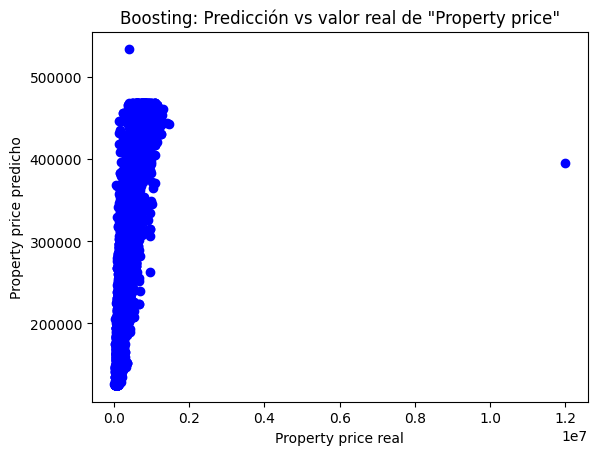

In [46]:
# Obtenemos las predicciones del modelo sobre los datos de test
y_pred = modelo_boostingR.predict(x_test)

plt.scatter(y_test, y_pred, color = 'blue') 
plt.title('Boosting: Predicción vs valor real de "Property price"')
plt.xlabel('Property price real')
plt.ylabel('Property price predicho')
plt.show()

In [47]:
# TEST

# Métricas en test
print('Métricas en test:',
      '\nMAE =', round(metrics.mean_absolute_error(y_test, y_pred),3),
      '\nMMSE =', round(metrics.mean_squared_error(y_test, y_pred),3),
      '\nRMSE =', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3),
      '\nR^2 =', round(modelo_boostingR.score(x_test, y_test),3))

Métricas en test: 
MAE = 66583.748 
MMSE = 19899468474.68 
RMSE = 141065.476 
R^2 = 0.438
